In [1]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [31]:
from keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(tokenizer.texts_to_sequences(train_data.tweet), maxlen = 30)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data.tweet), maxlen = 30)

print("X_train, X_test", X_train.shape, X_test.shape)

labels = train_data.label.unique().tolist()

X_train, X_test (1273862, 30) (318466, 30)


In [32]:
encoder = LabelEncoder()
encoder.fit(train_data.label.to_list())

y_train = encoder.transform(train_data.label.to_list())
y_test = encoder.transform(test_data.label.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1273862, 1)
y_test shape: (318466, 1)


# Training

### Agnes Model #1


In [42]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [43]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [44]:
sequence_input = Input(shape=(30,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)


model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [45]:
history = model.fit(X_train, y_train, batch_size=1024, epochs=10, validation_data=(X_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1245/1245 [==============================] - 897s 721ms/step - loss: 0.5181 - accuracy: 0.7408 - val_loss: 0.5016 - val_accuracy: 0.7541
Epoch 2/10
1245/1245 [==============================] - 775s 623ms/step - loss: 0.4897 - accuracy: 0.7625 - val_loss: 0.4815 - val_accuracy: 0.7702
Epoch 3/10
1245/1245 [==============================] - 865s 695ms/step - loss: 0.4793 - accuracy: 0.7694 - val_loss: 0.4739 - val_accuracy: 0.7746
Epoch 4/10
1245/1245 [==============================] - 865s 694ms/step - loss: 0.4737 - accuracy: 0.7731 - val_loss: 0.4704 - val_accuracy: 0.7752
Epoch 5/10
1245/1245 [==============================] - 842s 676ms/step - loss: 0.4696 - accuracy: 0.7752 - val_loss: 0.4733 - val_accuracy: 0.7752
Epoch 6/10
1245/1245 [==============================] - 753s 605ms/step - loss: 0.4664 - accuracy: 0.7773 - val_loss: 0.4693 - val_accuracy: 0.7780
Epoch 7/10
1245/1245 [==============================] - 750s 603ms/step - loss: 0.4643 - accuracy: 0.7789 - val_

In [46]:
model.save('models/Agnes_model.h5')

In [46]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [46]:
load_model = tf.keras.models.load_model('../models/Agnes_model.h5')

# Check its architecture
load_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           87137400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 64)            96064     
_________________________________________________________________
dense (Dense)                (None, 26, 512)           33280     
_________________________________________________________________
dropout (Dropout)            (None, 26, 512)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 26, 512)          

Text(0.5, 0, 'epoch')

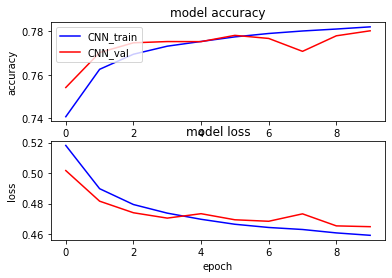

In [51]:
plt1, (plt2, plt3) = plt.subplots(2,1)
plt2.plot(history.history['accuracy'], c= 'blue')
plt2.plot(history.history['val_accuracy'], c='red')
plt2.set_title('model accuracy')
plt2.set_ylabel('accuracy')
plt2.set_xlabel('epoch')
plt2.legend(['Agnes_train', 'Agnes_val'], loc='upper left')

plt3.plot(history.history['loss'], c='blue')
plt3.plot(history.history['val_loss'], c='red')
plt3.set_title('model loss')
plt3.set_ylabel('loss')
plt3.set_xlabel('epoch')

In [52]:
def decode_labels(score):
    return "Positive" if score > 0.5 else "Negative"


scores = model.predict(X_test, verbose=1, batch_size=10000)
y_pred = [decode_labels(score) for score in scores]

32/32 [==============================] - 44s 1s/step


#### Confusion Matrix

[[124059  35434]
 [ 34587 124386]]


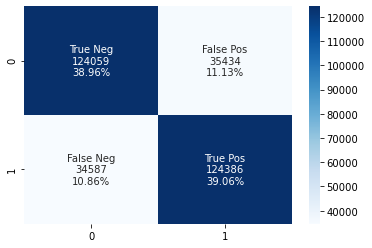

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

#Get the confusion matrix
cf_matrix = confusion_matrix(test_data.label.to_list(), y_pred)
print(cf_matrix)


#sns.heatmap(cf_matrix, annot=True)
#sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
#sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [54]:
print(classification_report(list(test_data.label), y_pred))

              precision    recall  f1-score   support

    Negative       0.78      0.78      0.78    159493
    Positive       0.78      0.78      0.78    158973

    accuracy                           0.78    318466
   macro avg       0.78      0.78      0.78    318466
weighted avg       0.78      0.78      0.78    318466



### Agnes Model #2


In [47]:
sequence_input = Input(shape=(30,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(32, 5, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)
model2 = tf.keras.Model(sequence_input, outputs)


model2.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.01, monitor = 'val_loss', verbose = 1)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [48]:
history2 = model2.fit(X_train, y_train, batch_size=512, epochs=10, validation_data=(X_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
2489/2489 [==============================] - 460s 185ms/step - loss: 0.5215 - accuracy: 0.7389 - val_loss: 0.4899 - val_accuracy: 0.7637
Epoch 2/10
2489/2489 [==============================] - 422s 170ms/step - loss: 0.4952 - accuracy: 0.7593 - val_loss: 0.4939 - val_accuracy: 0.7639
Epoch 3/10
2489/2489 [==============================] - 431s 173ms/step - loss: 0.4883 - accuracy: 0.7639 - val_loss: 0.4880 - val_accuracy: 0.7661
Epoch 4/10
2489/2489 [==============================] - 462s 186ms/step - loss: 0.4843 - accuracy: 0.7663 - val_loss: 0.4816 - val_accuracy: 0.7725
Epoch 5/10
2489/2489 [==============================] - 422s 170ms/step - loss: 0.4820 - accuracy: 0.7677 - val_loss: 0.4816 - val_accuracy: 0.7729
Epoch 6/10
2489/2489 [==============================] - 432s 174ms/step - loss: 0.4800 - accuracy: 0.7693 - val_loss: 0.4793 - val_accuracy: 0.7713
Epoch 7/10
2489/2489 [==============================] - 354s 142ms/step - loss: 0.4783 - accuracy: 0.7702 - val_

In [51]:
model2.save('../models/Agnes_model2.h5')

In [62]:
load_model2 = tf.keras.models.load_model('../models/Agnes_model2.h5')

# Check its architecture
load_model2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           87137400  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 32)            48032     
_________________________________________________________________
dense (Dense)                (None, 26, 256)           8448      
_________________________________________________________________
dropout (Dropout)            (None, 26, 256)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 26, 256)          

Text(0.5, 0, 'epoch')

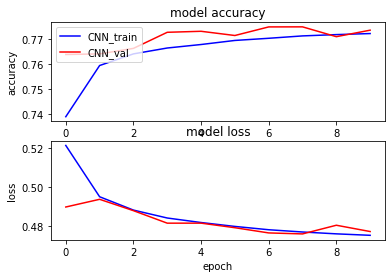

In [57]:
plt1, (plt2, plt3) = plt.subplots(2,1)
plt2.plot(history2.history['accuracy'], c= 'blue')
plt2.plot(history2.history['val_accuracy'], c='red')
plt2.set_title('model accuracy')
plt2.set_ylabel('accuracy')
plt2.set_xlabel('epoch')
plt2.legend(['Agnes_train', 'Agnes_val'], loc='upper left')

plt3.plot(history2.history['loss'], c='blue')
plt3.plot(history2.history['val_loss'], c='red')
plt3.set_title('model loss')
plt3.set_ylabel('loss')
plt3.set_xlabel('epoch')

In [59]:
def decode_labels(score):
    return "Positive" if score > 0.5 else "Negative"


scores = model2.predict(X_test, verbose=1, batch_size=10000)
y_pred = [decode_labels(score) for score in scores]

32/32 [==============================] - 20s 632ms/step


#### Confusion Matrix

[[115824  43669]
 [ 28499 130474]]


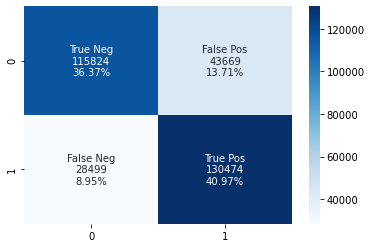

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

#Get the confusion matrix
cf_matrix = confusion_matrix(test_data.label.to_list(), y_pred)
print(cf_matrix)


#sns.heatmap(cf_matrix, annot=True)
#sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
#sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [61]:
print(classification_report(list(test_data.label), y_pred))

              precision    recall  f1-score   support

    Negative       0.80      0.73      0.76    159493
    Positive       0.75      0.82      0.78    158973

    accuracy                           0.77    318466
   macro avg       0.78      0.77      0.77    318466
weighted avg       0.78      0.77      0.77    318466



In [63]:
from sklearn.metrics import roc_curve
y_pred_Agnes1 = load_model.predict(X_test).ravel()
fpr_Agnes1, tpr_Agnes1, thresholds_Agnes1 = roc_curve(y_test, y_pred_Agnes1)
y_pred_Agnes2 = load_model2.predict(X_test).ravel()
fpr_Agnes2, tpr_Agnes2, thresholds_Agnes2 = roc_curve(y_test, y_pred_Agnes2)

In [64]:
#AUC calculation
from sklearn.metrics import auc
auc_Agnes1 = auc(fpr_Agnes1, tpr_Agnes1)
auc_Agnes2 = auc(fpr_Agnes2, tpr_Agnes2)

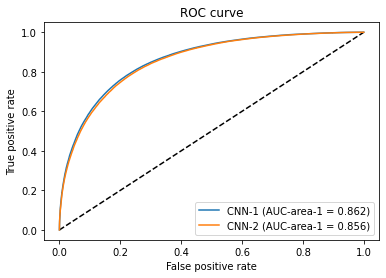

In [66]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Agnes1, tpr_Agnes1, label='Agnes-1 (AUC-area-1 = {:.3f})'.format(auc_Agnes1))
plt.plot(fpr_Agnes2, tpr_Agnes2, label='Agnes-2 (AUC-area-1 = {:.3f})'.format(auc_Agnes2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Entropy and Information Gain

In [69]:
from scipy.stats import entropy
from math import log, e
def entropy(labels, base=None):
    """ Computes entropy of label distribution. """

    n_labels = len(labels)

    if n_labels <= 1:
        return 0

    value,counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

    # Compute entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)

    return ent

In [70]:
ent_df = entropy(df)

In [71]:
ent_df

14.73368002815221

In [80]:
df_f = pd.read_csv('../data/training.1600000.processed.noemoticon.csv', header=None, encoding='latin')
df_f.columns = ['label', 'id', 'date', 'query', 'user', 'tweet']

In [76]:
# Data reduction
df_f =  df_f.drop(['id'], axis=1)

In [81]:
labels_dict = {0:'Negative', 2:'Neutral', 4:'Positive'}

def convert_labels(label):
    return labels_dict[label]

df_f.label = df_f.label.apply(lambda x: convert_labels(x))

In [85]:
ent_df_first = entropy(df_f)
ent_df_first

41.08269441306875